In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models: ANN, ELM, SVR, KRR, RF, XGB
from sklearn.neural_network import MLPRegressor
from skelm import ELMRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna
import shap

import warnings
warnings.filterwarnings('ignore')

Import the data

In [ ]:
rawdata = pd.read_excel("Data No Storage.xlsx")

In [ ]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PP1         86 non-null     int64  
 1   Nuclear     86 non-null     int64  
 2   Wind        86 non-null     int64  
 3   PV          86 non-null     int64  
 4   RH          86 non-null     int64  
 5   CSP         86 non-null     int64  
 6   Total Cost  86 non-null     int64  
 7   CO2         86 non-null     float64
 8   CEEP        86 non-null     float64
 9   Import      86 non-null     float64
 10  Export      86 non-null     float64
dtypes: float64(4), int64(7)
memory usage: 7.5 KB


In [ ]:
rawdata.describe()

,PP1,Nuclear,Wind,PV,RH,CSP,Total Cost,CO2,CEEP,Import,Export
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,100000.000000,15000.000000,7500.000000,100000.000000,10000.000000,25000.000000,143551.976744,367.402698,23.609767,116.786977,26.534302
std,43392.870111,13017.861033,6508.930517,86785.740222,8678.574022,21696.435056,29058.161498,86.268263,28.399385,155.346324,31.051040
min,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99252.000000,253.708000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127905.750000,277.893000,0.000000,0.000000,0.000000
50%,100000.000000,15000.000000,7500.000000,100000.000000,10000.000000,25000.000000,139028.000000,381.413500,8.330000,28.290000,10.740000
75%,150000.000000,30000.000000,15000.000000,200000.000000,20000.000000,50000.000000,160775.750000,408.540750,44.485000,203.845000,50.147500
max,150000.000000,30000.000000,15000.000000,200000.000000,20000.000000,50000.000000,213625.000000,557.687000,83.710000,507.800000,91.230000


In [ ]:
import random

def fixed_randomization(data):
    np.random.seed(42) 
    rand_data = data.sample(frac=1).reset_index(drop=True)
    return rand_data

rand_data = fixed_randomization(rawdata)

In [ ]:
rand_data.head(10)

,PP1,Nuclear,Wind,PV,RH,CSP,Total Cost,CO2,CEEP,Import,Export
0,100000,15000,7500,100000,10000,27500,130182,406.660,9.12,28.25,11.64
1,50000,0,0,0,0,0,179450,280.727,0.00,507.80,0.00
2,100000,15000,7500,90000,10000,25000,127616,409.021,5.56,28.45,7.48
3,50000,30000,15000,0,20000,0,127240,273.653,0.00,177.21,0.00
4,50000,0,15000,200000,0,0,167236,277.417,37.42,386.27,42.73
5,50000,0,0,200000,20000,50000,200417,277.028,64.99,339.02,72.04
6,50000,30000,0,200000,0,0,142318,261.752,38.66,208.17,43.66
7,50000,30000,0,0,20000,0,131808,276.729,0.00,202.69,0.00
8,50000,0,15000,0,0,0,174312,280.727,0.00,476.68,0.00
9,100000,16500,7500,100000,10000,25000,127665,402.012,8.33,25.65,10.74


In [ ]:
X_data_unscale = rand_data[rand_data.columns[0:6]]
Y_data_unscale = rand_data[rand_data.columns[6:11]]

Y_data = Y_data_unscale

In [ ]:
SS = StandardScaler()
MMS = MinMaxScaler()
X_data = SS.fit_transform(X_data_unscale)
X_data = pd.DataFrame(X_data)

In [ ]:
X_data.head(5)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.115902
1,-1.159021,-1.159021,-1.159021,-1.159021,-1.159021,-1.159021
2,0.000000,0.000000,0.000000,-0.115902,0.000000,0.000000
3,-1.159021,1.159021,1.159021,-1.159021,1.159021,-1.159021
4,-1.159021,-1.159021,1.159021,1.159021,-1.159021,-1.159021


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)

In [ ]:
y1_data = Y_data[Y_data.columns[0:1]]
y2_data = Y_data[Y_data.columns[1:2]]
y3_data = Y_data[Y_data.columns[2:3]]
y4_data = Y_data[Y_data.columns[3:4]]
y5_data = Y_data[Y_data.columns[4:5]]


y1_train = Y_train[Y_train.columns[0:1]]
y2_train = Y_train[Y_train.columns[1:2]]
y3_train = Y_train[Y_train.columns[2:3]]
y4_train = Y_train[Y_train.columns[3:4]]
y5_train = Y_train[Y_train.columns[4:5]]


y1_test = Y_test[Y_test.columns[0:1]]
y2_test = Y_test[Y_test.columns[1:2]]
y3_test = Y_test[Y_test.columns[2:3]]
y4_test = Y_test[Y_test.columns[3:4]]
y5_test = Y_test[Y_test.columns[4:5]]

In [ ]:
Y_test.describe()

,Total Cost,CO2,CEEP,Import,Export
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,152982.807692,373.427269,36.851538,110.342308,40.828077
std,31464.839843,89.549198,33.342696,160.108173,36.210631
min,101054.000000,257.297000,0.000000,0.000000,0.000000
25%,128564.500000,280.094000,2.082500,0.000000,2.692500
50%,154124.500000,387.663500,41.315000,26.950000,46.735000
75%,171992.500000,455.457000,69.707500,173.987500,76.137500
max,213625.000000,521.874000,83.710000,473.220000,91.230000


Metrics Function

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    # Extract values from DataFrames
    y_true_values = y_true.values.flatten()
    y_pred_values = y_pred.values.flatten()
    
    # R2 score
    r2 = r2_score(y_true_values, y_pred_values)
    r2 = round(r2, 4)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true_values, y_pred_values)
    mse = round(mse, 4)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse = round(rmse, 4)

    # Average Absolute Deviation (AAD)
    aad = np.mean(np.abs(y_true_values - y_pred_values))
    aad = round(aad, 4)
    
    # Squared Error Percentage (SEP)
    sep = np.mean(((y_true_values - y_pred_values) / y_true_values)**2) * 100
    sep = round(sep, 4)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true_values, y_pred_values)
    mae = round(mae, 4)
    
    '''print('r2: ', r2)
    print('mse: ', mse)
    print('rmse: ', rmse)
    print('aad: ', aad)
    print('sep: ', sep)
    print('mae: ', mae)'''   

    print(r2)
    print(mse)
    print(rmse)
    print(aad)
    print(sep)
    print(mae) 

# Random Forest

Y1

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9980317808539504
Test R_sq: 0.9846168103364605
Data R_sq: 0.9934964629559773
0.9935
5427581.5698
2329.7171
1394.6942
0.0179
1394.6942


In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)


# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

# Print the best trial
print('Best trial', study.best_trial)


[I 2024-05-19 22:46:42,358] A new study created in memory with name: regression


[I 2024-05-19 22:46:43,774] Trial 0 finished with value: -0.18485289474730626 and parameters: {'n_estimators': 423, 'max_depth': 23, 'min_samples_split': 45, 'min_samples_leaf': 14}. Best is trial 0 with value: -0.18485289474730626.
[I 2024-05-19 22:46:44,284] Trial 1 finished with value: -0.19504151136895964 and parameters: {'n_estimators': 185, 'max_depth': 54, 'min_samples_split': 63, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.18485289474730626.
[I 2024-05-19 22:46:44,591] Trial 2 finished with value: -0.20182694743334872 and parameters: {'n_estimators': 148, 'max_depth': 52, 'min_samples_split': 11, 'min_samples_leaf': 27}. Best is trial 0 with value: -0.18485289474730626.
[I 2024-05-19 22:46:45,626] Trial 3 finished with value: 0.34341744167306865 and parameters: {'n_estimators': 291, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 13}. Best is trial 3 with value: 0.34341744167306865.
[I 2024-05-19 22:46:47,540] Trial 4 finished with value: -0.187344423728

Best parameters {'n_estimators': 619, 'max_depth': 96, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best value 0.9862946256656039
Best trial FrozenTrial(number=83, state=1, values=[0.9862946256656039], datetime_start=datetime.datetime(2024, 5, 19, 22, 48, 19, 787222), datetime_complete=datetime.datetime(2024, 5, 19, 22, 48, 21, 651251), params={'n_estimators': 619, 'max_depth': 96, 'min_samples_split': 2, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=100, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=64, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=32, log=False, low=1, step=1)}, trial_id=83, value=None)


In [ ]:
rfy1_params = study.best_params
rf_model_y1 = RandomForestRegressor(**rfy1_params)
rf_model_y1.fit(X_train, y_train)

y_train_pred = rf_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9980682270970764
Test R_sq: 0.9864609657934857
Data R_sq: 0.9941546226819887
0.9942
4878308.8318
2208.6894
1288.464
0.0152
1288.464


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9982346026956966
Test R_sq: 0.961398201615598
Data R_sq: 0.9865643807248644
0.9866
98.8281
9.9412
4.648
0.0518
4.648


In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:49:03,024] A new study created in memory with name: regression


[I 2024-05-19 22:49:03,858] Trial 0 finished with value: 0.9048499782299779 and parameters: {'n_estimators': 399, 'max_depth': 100, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9048499782299779.
[I 2024-05-19 22:49:04,641] Trial 1 finished with value: 0.7135065303439971 and parameters: {'n_estimators': 370, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9048499782299779.
[I 2024-05-19 22:49:05,983] Trial 2 finished with value: 0.8299053899590592 and parameters: {'n_estimators': 578, 'max_depth': 63, 'min_samples_split': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9048499782299779.
[I 2024-05-19 22:49:07,066] Trial 3 finished with value: -0.009608631289728775 and parameters: {'n_estimators': 766, 'max_depth': 39, 'min_samples_split': 36, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.9048499782299779.
[I 2024-05-19 22:49:07,840] Trial 4 finished with value: 0.7238861932694035 and para

Best parameters {'n_estimators': 848, 'max_depth': 96, 'min_samples_split': 2, 'min_samples_leaf': 6}


In [ ]:
rfy2_params = study.best_params
rf_model_y2 = RandomForestRegressor(**rfy2_params)
rf_model_y2.fit(X_train, y_train)

y_train_pred = rf_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9450421657793646
Test R_sq: 0.9446398910936855
Data R_sq: 0.9450321908139854
0.945
404.3254
20.1078
13.3671
0.2512
13.3671


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9991134991637196
Test R_sq: 0.9754699489070654
Data R_sq: 0.989612442406503
0.9896
8.2804
2.8776
1.2332
nan
1.2332


In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:52:19,199] A new study created in memory with name: regression


[I 2024-05-19 22:52:19,966] Trial 0 finished with value: -0.3417246282783535 and parameters: {'n_estimators': 416, 'max_depth': 92, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: -0.3417246282783535.
[I 2024-05-19 22:52:21,702] Trial 1 finished with value: 0.8012484753223682 and parameters: {'n_estimators': 867, 'max_depth': 97, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8012484753223682.
[I 2024-05-19 22:52:22,081] Trial 2 finished with value: -0.3530242064346949 and parameters: {'n_estimators': 258, 'max_depth': 82, 'min_samples_split': 60, 'min_samples_leaf': 31}. Best is trial 1 with value: 0.8012484753223682.
[I 2024-05-19 22:52:22,906] Trial 3 finished with value: 0.25317105716914645 and parameters: {'n_estimators': 641, 'max_depth': 98, 'min_samples_split': 39, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.8012484753223682.
[I 2024-05-19 22:52:23,807] Trial 4 finished with value: 0.517114710036665 and par

Best parameters {'n_estimators': 442, 'max_depth': 94, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
rfy3_params = study.best_params
rf_model_y3 = RandomForestRegressor(**rfy3_params)
rf_model_y3.fit(X_train, y_train)

y_train_pred = rf_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9988930178459292
Test R_sq: 0.978196462530224
Data R_sq: 0.9906077462044552
0.9906
7.487
2.7362
1.196
nan
1.196


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9989285078101251
Test R_sq: 0.9947893027598668
Data R_sq: 0.9976361241582128
0.9976
56.3829
7.5089
3.5567
nan
3.5567


In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:54:14,492] A new study created in memory with name: regression
[I 2024-05-19 22:54:16,838] Trial 0 finished with value: 0.2711320344776371 and parameters: {'n_estimators': 960, 'max_depth': 23, 'min_samples_split': 21, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.2711320344776371.
[I 2024-05-19 22:54:17,742] Trial 1 finished with value: 0.260333443434402 and parameters: {'n_estimators': 378, 'max_depth': 86, 'min_samples_split': 25, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.2711320344776371.
[I 2024-05-19 22:54:18,369] Trial 2 finished with value: 0.0006867067278364392 and parameters: {'n_estimators': 414, 'max_depth': 17, 'min_samples_split': 31, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.2711320344776371.
[I 2024-05-19 22:54:19,003] Trial 3 finished with value: -0.002679740780457518 and parameters: {'n_estimators': 457, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 27}. Best is trial 0 with value: 0.2711320344776371.


Best parameters {'n_estimators': 442, 'max_depth': 99, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
rfy4_params = study.best_params
rf_model_y4 = RandomForestRegressor(**rfy4_params)
rf_model_y4.fit(X_train, y_train)

y_train_pred = rf_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9990579311686604
Test R_sq: 0.9950175408398838
Data R_sq: 0.9977963220714647
0.9978
52.5618
7.25
3.377
nan
3.377


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9991446867134322
Test R_sq: 0.97960685940463
Data R_sq: 0.9914093615798857
0.9914
8.1865
2.8612
1.2347
nan
1.2347


In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:56:33,707] A new study created in memory with name: regression
[I 2024-05-19 22:56:33,974] Trial 0 finished with value: -0.3349164553058914 and parameters: {'n_estimators': 119, 'max_depth': 18, 'min_samples_split': 64, 'min_samples_leaf': 28}. Best is trial 0 with value: -0.3349164553058914.
[I 2024-05-19 22:56:35,027] Trial 1 finished with value: -0.3306119192303556 and parameters: {'n_estimators': 474, 'max_depth': 18, 'min_samples_split': 42, 'min_samples_leaf': 29}. Best is trial 1 with value: -0.3306119192303556.
[I 2024-05-19 22:56:35,680] Trial 2 finished with value: -0.31902111005600653 and parameters: {'n_estimators': 208, 'max_depth': 96, 'min_samples_split': 48, 'min_samples_leaf': 3}. Best is trial 2 with value: -0.31902111005600653.
[I 2024-05-19 22:56:36,392] Trial 3 finished with value: 0.8298094404136932 and parameters: {'n_estimators': 346, 'max_depth': 96, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8298094404136932.

Best parameters {'n_estimators': 659, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
rfy5_params = study.best_params
rf_model_y5 = RandomForestRegressor(**rfy5_params)
rf_model_y5.fit(X_train, y_train)

y_train_pred = rf_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9989811293292199
Test R_sq: 0.9797700607742822
Data R_sq: 0.991391697416792
0.9914
8.2033
2.8641
1.2594
nan
1.2594


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# Support Vector Regression

In [ ]:
svr = SVR()

## No Cross Validation

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)


[I 2024-05-19 22:59:08,263] A new study created in memory with name: regression


[I 2024-05-19 22:59:09,216] Trial 0 finished with value: 0.9733977859710485 and parameters: {'C': 919102.3394749481, 'epsilon': 9.76433980492617, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.09891689033195063}. Best is trial 0 with value: 0.9733977859710485.
[I 2024-05-19 22:59:09,263] Trial 1 finished with value: 0.9849428435616673 and parameters: {'C': 499203.82633192616, 'epsilon': 2.9589590113095423, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.08925143081919262}. Best is trial 1 with value: 0.9849428435616673.
[I 2024-05-19 22:59:09,295] Trial 2 finished with value: 0.39873027211595635 and parameters: {'C': 15347.801146479263, 'epsilon': 9.20516603185315, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.020541004995152202}. Best is trial 1 with value: 0.9849428435616673.
[I 2024-05-19 22:59:09,351] Trial 3 finished with value: 0.9888948436556472 and parameters: {'C': 805787.3793552855, 'epsilon': 2.3101582422062084, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.07805937684473996}. Best is trial 3 with

Best parameters {'C': 889908.6056884271, 'epsilon': 0.11777148769815615, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.017472079610730055}


In [ ]:
# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

# Print the best trial
print('Best trial', study.best_trial)

Best parameters {'C': 889908.6056884271, 'epsilon': 0.11777148769815615, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.017472079610730055}
Best value 0.9996709668276869
Best trial FrozenTrial(number=32, state=1, values=[0.9996709668276869], datetime_start=datetime.datetime(2024, 5, 19, 22, 59, 11, 924312), datetime_complete=datetime.datetime(2024, 5, 19, 22, 59, 12, 74302), params={'C': 889908.6056884271, 'epsilon': 0.11777148769815615, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.017472079610730055}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=1000000.0, log=False, low=1e-06, step=None), 'epsilon': FloatDistribution(high=10.0, log=False, low=1e-06, step=None), 'kernel': CategoricalDistribution(choices=('rbf',)), 'degree': IntDistribution(high=5, log=False, low=1, step=1), 'gamma': FloatDistribution(high=0.1, log=False, low=1e-05, step=None)}, trial_id=32, value=None)


In [ ]:
svr_param_y1 = study.best_params

svr_model_y1 = SVR(**svr_param_y1)
svr_model_y1.fit(X_train, y_train)

y_train_pred = svr_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999705735068682
Test R_sq: 0.9996709668276869
Data R_sq: 0.9998686117533669
0.9999
109651.1669
331.1362
154.9953
0.0006
154.9953


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:59:26,093] A new study created in memory with name: regression


[I 2024-05-19 22:59:26,160] Trial 0 finished with value: 0.8485879663262381 and parameters: {'C': 308708.9414123748, 'epsilon': 6.5050806391962706, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.0002708734257283786}. Best is trial 0 with value: 0.8485879663262381.
[I 2024-05-19 22:59:26,185] Trial 1 finished with value: 0.9676259780952925 and parameters: {'C': 559579.0319893791, 'epsilon': 4.046972434848211, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.05893435085138226}. Best is trial 1 with value: 0.9676259780952925.
[I 2024-05-19 22:59:26,314] Trial 2 finished with value: 0.9968298763924853 and parameters: {'C': 588864.8831299063, 'epsilon': 5.426983224730703, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.004208181402805707}. Best is trial 2 with value: 0.9968298763924853.
[I 2024-05-19 22:59:26,335] Trial 3 finished with value: 0.9935928801780232 and parameters: {'C': 401262.5959666771, 'epsilon': 6.812603993225854, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.0099621605265953}. Best is trial 2 with 

Best parameters {'C': 567754.8073493874, 'epsilon': 0.04917487660012416, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.002912874794411995}


In [ ]:
svr_param_y2 = study.best_params

svr_model_y2 = SVR(**svr_param_y2)
svr_model_y2.fit(X_train, y_train)

y_train_pred = svr_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999660861047555
Test R_sq: 0.9994037312303915
Data R_sq: 0.9997879400971424
0.9998
1.5598
1.2489
0.6687
0.0014
0.6687


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 22:59:52,115] A new study created in memory with name: regression


[I 2024-05-19 22:59:52,174] Trial 0 finished with value: 0.9844322971627177 and parameters: {'C': 181086.35444975432, 'epsilon': 0.8092677526437713, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.019021963369001516}. Best is trial 0 with value: 0.9844322971627177.
[I 2024-05-19 22:59:52,203] Trial 1 finished with value: 0.887604105565471 and parameters: {'C': 112388.94389101292, 'epsilon': 6.3991803786119865, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.0635103994284902}. Best is trial 0 with value: 0.9844322971627177.
[I 2024-05-19 22:59:52,220] Trial 2 finished with value: 0.8459115028230415 and parameters: {'C': 447593.9212050841, 'epsilon': 8.653164467103364, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.07290611285146804}. Best is trial 0 with value: 0.9844322971627177.
[I 2024-05-19 22:59:52,238] Trial 3 finished with value: 0.9363779513046061 and parameters: {'C': 143513.50479851261, 'epsilon': 3.8237626510607554, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.0466300512622902}. Best is trial 0 with

Best parameters {'C': 653379.5949488326, 'epsilon': 0.006785960166006522, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.008068725222563553}


# Start

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

NameError: name 'y3_data' is not defined

In [ ]:
svr_param_y3 = study.best_params

svr_model_y3 = SVR(**svr_param_y3)
svr_model_y3.fit(X_train, y_train)

y_train_pred = svr_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

# End

In [ ]:
svr_param_y3 = study.best_params

svr_model_y3 = SVR(**svr_param_y3)
svr_model_y3.fit(X_train, y_train)

y_train_pred = svr_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999898413352752
Test R_sq: 0.9963010428084842
Data R_sq: 0.9984952987690796
0.9985
1.1995
1.0952
0.3468
inf
0.3468


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 23:00:17,909] A new study created in memory with name: regression


[I 2024-05-19 23:00:17,996] Trial 0 finished with value: 0.9121103532277467 and parameters: {'C': 363583.63147620636, 'epsilon': 0.7647213788698197, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.05068860244837064}. Best is trial 0 with value: 0.9121103532277467.
[I 2024-05-19 23:00:18,011] Trial 1 finished with value: 0.9511109188554769 and parameters: {'C': 943396.3285799215, 'epsilon': 7.281225140191391, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.08339925080649535}. Best is trial 1 with value: 0.9511109188554769.
[I 2024-05-19 23:00:18,028] Trial 2 finished with value: 0.9960876359865727 and parameters: {'C': 316592.63487232046, 'epsilon': 9.217861098492808, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.016084282910493956}. Best is trial 2 with value: 0.9960876359865727.
[I 2024-05-19 23:00:18,062] Trial 3 finished with value: 0.8737761745173921 and parameters: {'C': 338739.47463002277, 'epsilon': 0.8816055545749398, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.07570569635647909}. Best is trial 2 wi

Best parameters {'C': 831885.8768976415, 'epsilon': 6.094759960876085, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.005314081870230898}


In [ ]:
svr_param_y4 = study.best_params

svr_model_y4 = SVR(**svr_param_y4)
svr_model_y4.fit(X_train, y_train)

y_train_pred = svr_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9989373933233756
Test R_sq: 0.9988559006585718
Data R_sq: 0.9989127347708888
0.9989
25.9333
5.0925
4.6802
inf
4.6802


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 23:00:32,995] A new study created in memory with name: regression
[I 2024-05-19 23:00:33,026] Trial 0 finished with value: 0.934680471388688 and parameters: {'C': 26014.684016325882, 'epsilon': 8.249423882528694, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.004944422950876035}. Best is trial 0 with value: 0.934680471388688.


[I 2024-05-19 23:00:33,063] Trial 1 finished with value: 0.9632434402673528 and parameters: {'C': 234542.58479662734, 'epsilon': 2.466709281988049, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.0390012068560227}. Best is trial 1 with value: 0.9632434402673528.
[I 2024-05-19 23:00:33,098] Trial 2 finished with value: 0.9455038376107828 and parameters: {'C': 687647.6946487162, 'epsilon': 2.137227176947615, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.06484533346239055}. Best is trial 1 with value: 0.9632434402673528.
[I 2024-05-19 23:00:33,114] Trial 3 finished with value: 0.9416218111834193 and parameters: {'C': 473634.5654814912, 'epsilon': 0.3521295184787909, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.06298789912572184}. Best is trial 1 with value: 0.9632434402673528.
[I 2024-05-19 23:00:33,126] Trial 4 finished with value: 0.9286619585389342 and parameters: {'C': 638012.8055135158, 'epsilon': 3.193779368844589, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.07081872783109987}. Best is trial 1 with va

Best parameters {'C': 859806.8481463918, 'epsilon': 0.006635153536730734, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.013642058610357263}


In [ ]:
svr_param_y5 = study.best_params

svr_model_y5 = SVR(**svr_param_y5)
svr_model_y5.fit(X_train, y_train)

y_train_pred = svr_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999854062761127
Test R_sq: 0.9983524401148276
Data R_sq: 0.9993336042519431
0.9993
0.635
0.7969
0.3375
inf
0.3375


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# XGBoost

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:01:10,292] A new study created in memory with name: regression
[I 2024-05-19 23:01:11,835] Trial 0 finished with value: 0.8778578835573967 and parameters: {'max_depth': 6, 'learning_rate': 0.38135816250499105, 'n_estimators': 125, 'min_child_weight': 9, 'gamma': 0.3363334601782435, 'subsample': 0.5351316266183729, 'colsample_bytree': 0.36910944201647056, 'reg_alpha': 0.899128866219329, 'reg_lambda': 0.06712531043830658, 'random_state': 724}. Best is trial 0 with value: 0.8778578835573967.
[I 2024-05-19 23:01:12,053] Trial 1 finished with value: 0.9133802719884038 and parameters: {'max_depth': 8, 'learning_rate': 0.04208539134061553, 'n_estimators': 396, 'min_child_weight': 4, 'gamma': 0.6520446353591605, 'subsample': 0.7702737227707616, 'colsample_bytree': 0.13362854001015806, 'reg_alpha': 0.32336753967747633, 'reg_lambda': 0.9891922864320336, 'random_state': 524}. Best is trial 1 with value: 0.9133802719884038.
[I 2024-05-19 23:01:12,147] Trial 2 finished with value: 

Best parameters {'max_depth': 3, 'learning_rate': 0.6559938747200145, 'n_estimators': 742, 'min_child_weight': 5, 'gamma': 0.2364570538403641, 'subsample': 0.9166005202188677, 'colsample_bytree': 0.5467984466797525, 'reg_alpha': 0.34210178318639684, 'reg_lambda': 0.6058891382532333, 'random_state': 590}
Best value 0.9986331969120074


In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


y_train_pred = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)


Train R_sq: 0.9999999999991774
Test R_sq: 0.9305992040548196
Data R_sq: 0.9760668248547535


In [ ]:
xgb_params_y1 = study.best_params

xgb_model_y1 = XGBRegressor(**xgb_params_y1)
xgb_model_y1.fit(X_train, y_train)

y_train_pred = xgb_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999949423240188
Test R_sq: 0.9986331969120074
Data R_sq: 0.9995255718926018
0.9995
395937.9695
629.236
275.6711
0.0021
275.6711


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:01:57,209] A new study created in memory with name: regression
[I 2024-05-19 23:01:57,392] Trial 0 finished with value: -0.00698977574648274 and parameters: {'max_depth': 2, 'learning_rate': 0.9073025936087259, 'n_estimators': 441, 'min_child_weight': 6, 'gamma': 0.4519533427333167, 'subsample': 0.032002731742668634, 'colsample_bytree': 0.5426973436410477, 'reg_alpha': 0.05183997476630739, 'reg_lambda': 0.9441454635976001, 'random_state': 713}. Best is trial 0 with value: -0.00698977574648274.
[I 2024-05-19 23:01:57,503] Trial 1 finished with value: 0.910860488572243 and parameters: {'max_depth': 7, 'learning_rate': 0.9812629811015994, 'n_estimators': 399, 'min_child_weight': 10, 'gamma': 0.3250588045976026, 'subsample': 0.6433372214694527, 'colsample_bytree': 0.48288298424476606, 'reg_alpha': 0.24711508860187886, 'reg_lambda': 0.3414286256953063, 'random_state': 843}. Best is trial 1 with value: 0.910860488572243.
[I 2024-05-19 23:01:57,723] Trial 2 finished with valu

Best parameters {'max_depth': 8, 'learning_rate': 0.8058929837921041, 'n_estimators': 707, 'min_child_weight': 6, 'gamma': 0.6203690244688376, 'subsample': 0.8633675242642986, 'colsample_bytree': 0.351803542599373, 'reg_alpha': 0.38202482253134534, 'reg_lambda': 0.19326434501771286, 'random_state': 507}
Best value 0.9959756506101234


In [ ]:
xgb_params_y2 = study.best_params

xgb_model_y2 = XGBRegressor(**xgb_params_y2)
xgb_model_y2.fit(X_train, y_train)

y_train_pred = xgb_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.999332732605656
Test R_sq: 0.9959756506101234
Data R_sq: 0.9982702507552352
0.9983
12.7235
3.567
2.2971
0.012
2.2971


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:02:36,602] A new study created in memory with name: regression
[I 2024-05-19 23:02:36,884] Trial 0 finished with value: 0.8740807300903266 and parameters: {'max_depth': 2, 'learning_rate': 0.9218079594191774, 'n_estimators': 722, 'min_child_weight': 2, 'gamma': 0.9516211487047609, 'subsample': 0.9106128156988638, 'colsample_bytree': 0.3139617590368622, 'reg_alpha': 0.2572009240317081, 'reg_lambda': 0.11443337534710833, 'random_state': 89}. Best is trial 0 with value: 0.8740807300903266.
[I 2024-05-19 23:02:36,939] Trial 1 finished with value: 0.9909986560046685 and parameters: {'max_depth': 6, 'learning_rate': 0.7720602622929281, 'n_estimators': 103, 'min_child_weight': 5, 'gamma': 0.6600250530988936, 'subsample': 0.4015742928052732, 'colsample_bytree': 0.7155071382161191, 'reg_alpha': 0.9252721617156237, 'reg_lambda': 0.19562892397116208, 'random_state': 356}. Best is trial 1 with value: 0.9909986560046685.
[I 2024-05-19 23:02:37,039] Trial 2 finished with value: 0.98

Best parameters {'max_depth': 3, 'learning_rate': 0.5560764434875813, 'n_estimators': 581, 'min_child_weight': 1, 'gamma': 0.17663683708839756, 'subsample': 0.22400187438994715, 'colsample_bytree': 0.45123077147598545, 'reg_alpha': 0.8358287950607348, 'reg_lambda': 0.3030245049556971, 'random_state': 475}
Best value 0.993049111379287


In [ ]:
xgb_params_y3 = study.best_params

xgb_model_y3 = XGBRegressor(**xgb_params_y3)
xgb_model_y3.fit(X_train, y_train)

y_train_pred = xgb_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9982336808284477
Test R_sq: 0.993049111379287
Data R_sq: 0.9963001176444282
0.9963
2.9493
1.7174
1.1509
inf
1.1509


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:03:08,646] A new study created in memory with name: regression
[I 2024-05-19 23:03:08,969] Trial 0 finished with value: 0.9413056220442538 and parameters: {'max_depth': 7, 'learning_rate': 0.8848265158046708, 'n_estimators': 784, 'min_child_weight': 1, 'gamma': 0.42693814556389936, 'subsample': 0.6377283981842599, 'colsample_bytree': 0.664997072418011, 'reg_alpha': 0.7634388299707817, 'reg_lambda': 0.711607406942875, 'random_state': 714}. Best is trial 0 with value: 0.9413056220442538.
[I 2024-05-19 23:03:09,116] Trial 1 finished with value: 0.8346940998394887 and parameters: {'max_depth': 1, 'learning_rate': 0.5286840836695238, 'n_estimators': 757, 'min_child_weight': 3, 'gamma': 0.8688590558707786, 'subsample': 0.49979694694809584, 'colsample_bytree': 0.3711831112826072, 'reg_alpha': 0.5016290821123738, 'reg_lambda': 0.025115158478039523, 'random_state': 168}. Best is trial 0 with value: 0.9413056220442538.
[I 2024-05-19 23:03:09,333] Trial 2 finished with value: 0.9

Best parameters {'max_depth': 10, 'learning_rate': 0.43666973070690324, 'n_estimators': 828, 'min_child_weight': 8, 'gamma': 0.28078926083310424, 'subsample': 0.6681118230081214, 'colsample_bytree': 0.4876447096098242, 'reg_alpha': 0.29034765465801493, 'reg_lambda': 0.3669174369705459, 'random_state': 949}
Best value 0.9938585729072889


In [ ]:
xgb_params_y4 = study.best_params

xgb_model_y4 = XGBRegressor(**xgb_params_y4)
xgb_model_y4.fit(X_train, y_train)

y_train_pred = xgb_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.999194161064959
Test R_sq: 0.9938585729072889
Data R_sq: 0.9975277966676785
0.9975
58.9667
7.679
4.6877
inf
4.6877


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:03:52,180] A new study created in memory with name: regression


[I 2024-05-19 23:03:52,435] Trial 0 finished with value: 0.9008923060302977 and parameters: {'max_depth': 1, 'learning_rate': 0.3707103440592755, 'n_estimators': 643, 'min_child_weight': 7, 'gamma': 0.010823980167247043, 'subsample': 0.9919209690368138, 'colsample_bytree': 0.5953333012189873, 'reg_alpha': 0.588487205402825, 'reg_lambda': 0.9150503135626814, 'random_state': 613}. Best is trial 0 with value: 0.9008923060302977.
[I 2024-05-19 23:03:52,784] Trial 1 finished with value: 0.9863655165021402 and parameters: {'max_depth': 7, 'learning_rate': 0.8363690769170548, 'n_estimators': 911, 'min_child_weight': 2, 'gamma': 0.05752929191031029, 'subsample': 0.4699764863584634, 'colsample_bytree': 0.7411304520422601, 'reg_alpha': 0.2673311960200068, 'reg_lambda': 0.6429763542042766, 'random_state': 28}. Best is trial 1 with value: 0.9863655165021402.
[I 2024-05-19 23:03:53,073] Trial 2 finished with value: 0.9122619567122118 and parameters: {'max_depth': 1, 'learning_rate': 0.1535932099168

Best parameters {'max_depth': 7, 'learning_rate': 0.6716152082426471, 'n_estimators': 775, 'min_child_weight': 4, 'gamma': 0.17452459862373565, 'subsample': 0.6822204038346688, 'colsample_bytree': 0.8569076637819095, 'reg_alpha': 0.2644856806500062, 'reg_lambda': 0.13711826513165448, 'random_state': 712}
Best value 0.9961865505467218


In [ ]:
xgb_params_y5 = study.best_params

xgb_model_y5 = XGBRegressor(**xgb_params_y5)
xgb_model_y5.fit(X_train, y_train)

y_train_pred = xgb_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9998514955922968
Test R_sq: 0.9961865505467218
Data R_sq: 0.9983993786891895
0.9984
1.5253
1.235
0.64
inf
0.64


In [ ]:
xgb_params_y5 = study.best_params

xgb_model_y5 = XGBRegressor(**xgb_params_y5)
xgb_model_y5.fit(X_train, y_train)

y_train_pred = xgb_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9998514955922968
Test R_sq: 0.9961865505467218
Data R_sq: 0.9983993786891895


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

In [ ]:
# Save a model using pickle

# filename = "xgbregressor.pkl"
# pickle.dump(model, open(filename, "wb"))

# Neural Network

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=20)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:04:34,841] A new study created in memory with name: regression
[I 2024-05-19 23:04:35,355] Trial 0 finished with value: -20.720571339390837 and parameters: {'layer_size_0': 45, 'layer_size_1': 50, 'layer_size_2': 38, 'layer_size_3': 25, 'activation': 'relu', 'solver': 'adam', 'random_state': 74, 'alpha': 0.6925421929655243}. Best is trial 0 with value: -20.720571339390837.
[I 2024-05-19 23:04:35,703] Trial 1 finished with value: -24.496273121786608 and parameters: {'layer_size_0': 15, 'layer_size_1': 33, 'layer_size_2': 13, 'layer_size_3': 12, 'activation': 'relu', 'solver': 'adam', 'random_state': 20, 'alpha': 0.12749940590016895}. Best is trial 0 with value: -20.720571339390837.
[I 2024-05-19 23:04:36,262] Trial 2 finished with value: 0.9624623246706488 and parameters: {'layer_size_0': 30, 'layer_size_1': 1, 'layer_size_2': 33, 'layer_size_3': 5, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 100, 'alpha': 0.07700838387882257}. Best is trial 2 with value: 0

Best parameters {'layer_size_0': 10, 'layer_size_1': 37, 'layer_size_2': 44, 'layer_size_3': 50, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 36, 'alpha': 0.6036630892634247}
Best value 0.9977311985320418


In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:04:44,460] A new study created in memory with name: regression
[I 2024-05-19 23:04:45,000] Trial 0 finished with value: 0.9786781786759569 and parameters: {'layer_size_0': 42, 'layer_size_1': 30, 'layer_size_2': 16, 'layer_size_3': 21, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 50, 'alpha': 0.24808462086314897}. Best is trial 0 with value: 0.9786781786759569.
[I 2024-05-19 23:04:45,389] Trial 1 finished with value: 0.9859138690285827 and parameters: {'layer_size_0': 17, 'layer_size_1': 41, 'layer_size_2': 8, 'layer_size_3': 42, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 54, 'alpha': 0.9231544553575393}. Best is trial 1 with value: 0.9859138690285827.
[I 2024-05-19 23:04:45,781] Trial 2 finished with value: -23.78323258894819 and parameters: {'layer_size_0': 8, 'layer_size_1': 30, 'layer_size_2': 34, 'layer_size_3': 45, 'activation': 'relu', 'solver': 'adam', 'random_state': 25, 'alpha': 0.6644009643409288}. Best is trial 1 with value: 0.9859

Best parameters {'layer_size_0': 45, 'layer_size_1': 3, 'layer_size_2': 22, 'layer_size_3': 9, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 41, 'alpha': 0.12259107209090192}
Best value 0.9976135250509844


In [ ]:
ann_model_y1 = MLPRegressor(hidden_layer_sizes=(8, 30, 50, 32), activation='relu', alpha=0.13762346635059558, solver='lbfgs', random_state=3)

# Fit the model on the training data
ann_model_y1.fit(X_train, y_train)

y_train_pred = ann_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9998607075485301
Test R_sq: 0.9987506318979854
Data R_sq: 0.9994843256848348


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:05:31,540] A new study created in memory with name: regression
[I 2024-05-19 23:05:31,955] Trial 0 finished with value: 0.08918170791054503 and parameters: {'layer_size_0': 20, 'layer_size_1': 40, 'layer_size_2': 45, 'layer_size_3': 49, 'activation': 'relu', 'solver': 'adam', 'random_state': 44, 'alpha': 0.8662396181058032}. Best is trial 0 with value: 0.08918170791054503.
[I 2024-05-19 23:05:32,317] Trial 1 finished with value: 0.03138695914215728 and parameters: {'layer_size_0': 21, 'layer_size_1': 37, 'layer_size_2': 24, 'layer_size_3': 28, 'activation': 'relu', 'solver': 'adam', 'random_state': 30, 'alpha': 0.30462710819123}. Best is trial 0 with value: 0.08918170791054503.
[I 2024-05-19 23:05:32,640] Trial 2 finished with value: -0.28944463980568047 and parameters: {'layer_size_0': 44, 'layer_size_1': 41, 'layer_size_2': 7, 'layer_size_3': 19, 'activation': 'relu', 'solver': 'adam', 'random_state': 14, 'alpha': 0.8793212830629744}. Best is trial 0 with value: 0.08

Best parameters {'layer_size_0': 41, 'layer_size_1': 12, 'layer_size_2': 32, 'layer_size_3': 23, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 3, 'alpha': 0.5186668567666814}
Best value 0.9991724080599216


In [ ]:
ann_model_y2 = MLPRegressor(hidden_layer_sizes=(40, 36, 17, 3), activation='relu', alpha=0.421732762333308, solver='lbfgs', random_state=34)

# Fit the model on the training data
ann_model_y2.fit(X_train, y_train)

y_train_pred = ann_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9999976086051479
Test R_sq: 0.996803935252103
Data R_sq: 0.9989854917052633


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:06:27,863] A new study created in memory with name: regression
[I 2024-05-19 23:06:28,150] Trial 0 finished with value: 0.9905316301658286 and parameters: {'layer_size_0': 2, 'layer_size_1': 7, 'layer_size_2': 47, 'layer_size_3': 38, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 16, 'alpha': 0.29560199339790016}. Best is trial 0 with value: 0.9905316301658286.
[I 2024-05-19 23:06:28,741] Trial 1 finished with value: 0.9946353733248736 and parameters: {'layer_size_0': 19, 'layer_size_1': 50, 'layer_size_2': 36, 'layer_size_3': 45, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 30, 'alpha': 0.08380245643932396}. Best is trial 1 with value: 0.9946353733248736.
[I 2024-05-19 23:06:29,218] Trial 2 finished with value: 0.980472058911234 and parameters: {'layer_size_0': 19, 'layer_size_1': 47, 'layer_size_2': 26, 'layer_size_3': 34, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 82, 'alpha': 0.9072842583836889}. Best is trial 1 with value: 0.994

Best parameters {'layer_size_0': 9, 'layer_size_1': 25, 'layer_size_2': 29, 'layer_size_3': 40, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 38, 'alpha': 0.3820823573409181}
Best value 0.9978746328756133


In [ ]:
ann_model_y3 = MLPRegressor(hidden_layer_sizes=(38, 20, 2, 36), activation='relu', alpha=0.1368361449397597, solver='lbfgs', random_state=100)

# Fit the model on the training data
ann_model_y3.fit(X_train, y_train)

y_train_pred = ann_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9999950935401009
Test R_sq: 0.989724490774666
Data R_sq: 0.9958316585280386


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:07:22,261] A new study created in memory with name: regression
[I 2024-05-19 23:07:22,646] Trial 0 finished with value: 0.9991236352510777 and parameters: {'layer_size_0': 17, 'layer_size_1': 32, 'layer_size_2': 35, 'layer_size_3': 18, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 13, 'alpha': 0.013741175536175907}. Best is trial 0 with value: 0.9991236352510777.
[I 2024-05-19 23:07:23,115] Trial 1 finished with value: 0.998332205863505 and parameters: {'layer_size_0': 33, 'layer_size_1': 17, 'layer_size_2': 50, 'layer_size_3': 41, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 42, 'alpha': 0.6558966720606458}. Best is trial 0 with value: 0.9991236352510777.
[I 2024-05-19 23:07:23,442] Trial 2 finished with value: 0.7658830827616596 and parameters: {'layer_size_0': 46, 'layer_size_1': 11, 'layer_size_2': 25, 'layer_size_3': 25, 'activation': 'relu', 'solver': 'adam', 'random_state': 22, 'alpha': 0.19126695393769969}. Best is trial 0 with value: 0.9

Best parameters {'layer_size_0': 11, 'layer_size_1': 29, 'layer_size_2': 10, 'layer_size_3': 14, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 20, 'alpha': 0.9089548578177905}
Best value 0.9999595675933177


In [ ]:
ann_model_y4 = MLPRegressor(hidden_layer_sizes=(33, 10, 8, 40), activation='relu', alpha=0.20068666427656182, solver='lbfgs', random_state=52)

# Fit the model on the training data
ann_model_y4.fit(X_train, y_train)

y_train_pred = ann_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9999982421696942
Test R_sq: 0.9998064287733573
Data R_sq: 0.9999383161479076


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 23:08:12,189] A new study created in memory with name: regression
[I 2024-05-19 23:08:12,719] Trial 0 finished with value: 0.9855782061673396 and parameters: {'layer_size_0': 34, 'layer_size_1': 27, 'layer_size_2': 23, 'layer_size_3': 14, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 37, 'alpha': 0.0377927032225948}. Best is trial 0 with value: 0.9855782061673396.
[I 2024-05-19 23:08:13,133] Trial 1 finished with value: 0.9982671369815689 and parameters: {'layer_size_0': 30, 'layer_size_1': 8, 'layer_size_2': 50, 'layer_size_3': 50, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 99, 'alpha': 0.9360016880053423}. Best is trial 1 with value: 0.9982671369815689.
[I 2024-05-19 23:08:13,598] Trial 2 finished with value: 0.9872762705655412 and parameters: {'layer_size_0': 29, 'layer_size_1': 29, 'layer_size_2': 39, 'layer_size_3': 45, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 58, 'alpha': 0.0018750892532582053}. Best is trial 1 with value: 0.

Best parameters {'layer_size_0': 6, 'layer_size_1': 39, 'layer_size_2': 21, 'layer_size_3': 17, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 39, 'alpha': 0.7161243122832393}
Best value 0.9985718402527872


In [ ]:
ann_model_y5 = MLPRegressor(hidden_layer_sizes=(31, 33, 25, 22), activation='relu', alpha=0.13947601768544515, solver='lbfgs', random_state=13)

# Fit the model on the training data
ann_model_y5.fit(X_train, y_train)

y_train_pred = ann_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9999718773941864
Test R_sq: 0.9954369102291898
Data R_sq: 0.9981605827030292


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# Shap

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Model for y1
y1_params = {'C': 792455.0628709563, 'epsilon': 1.615158320784387, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.018028712570561923}
model_y1 = SVR(**y1_params)
model_y1.fit(X_train, y_train)
y1_pred = model_y1.predict(X_test)

y_data = y2_data
y_train = y2_train
y_test = y2_test
# Model for y2
y2_params = {'C': 35529.565119700674, 'epsilon': 0.01398121990100254, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.00759513082892152}
model_y2 = SVR(**y2_params)
model_y2.fit(X_train, y_train)
y2_pred = model_y2.predict(X_test)

y_data = y3_data
y_train = y3_train
y_test = y3_test
# Model for y3
y3_params = {'C': 741046.8928371427, 'epsilon': 0.010895466956371502, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.009751068786055191}
model_y3 = SVR(**y3_params)
model_y3.fit(X_train, y_train)
y3_pred = model_y3.predict(X_test)

y_data = y4_data
y_train = y4_train
y_test = y4_test
# Model for y4
model_y4 = MLPRegressor(hidden_layer_sizes=(33, 10, 8, 40), activation='relu', alpha=0.20068666427656182, solver='lbfgs', random_state=52)
model_y4.fit(X_train, y_train)
y4_pred = model_y4.predict(X_test)

In [ ]:

# Copy column names from df_source to df_target
X_data.columns = X_data_unscale.columns


In [ ]:
import pandas as pd

# Your list
mm = [1.11956119, -0.0427942,   0.02750056, -0.72244753,  0.13830575, -1.15761651]

# Convert to DataFrame
df = pd.DataFrame(mm)
df = df.T
df.columns = X_data_unscale.columns

# Display the DataFrame
print(df)


        PP1   Nuclear      Wind        PV        RH       CSP
0  1.119561 -0.042794  0.027501 -0.722448  0.138306 -1.157617


  0%|          | 0/1 [00:00<?, ?it/s]

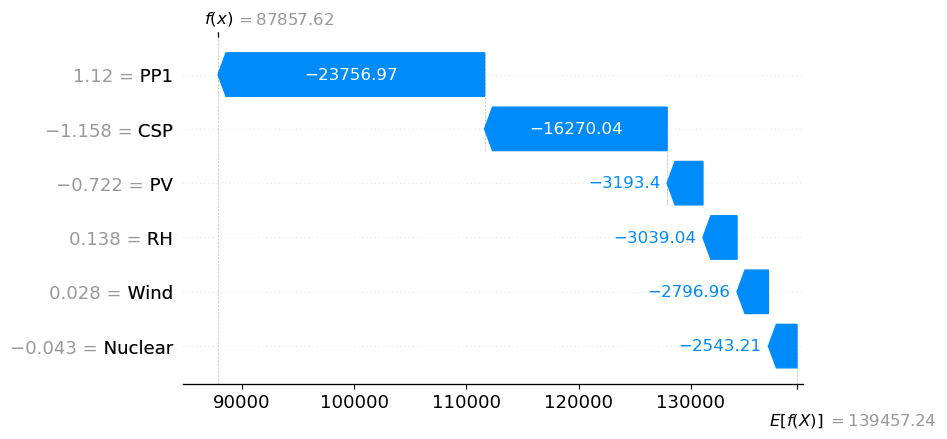

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


y1_params = {'C': 792455.0628709563, 'epsilon': 1.615158320784387, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.018028712570561923}
model_y1 = SVR(**y1_params)
model_y1.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.KernelExplainer(model_y1.predict, X_train)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

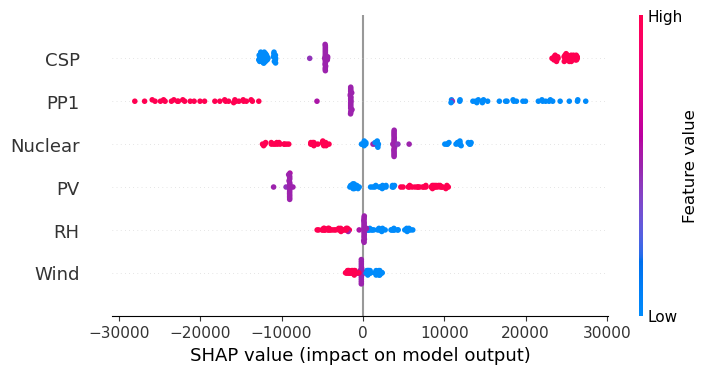

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


mod_1 = {'max_depth': 3, 'learning_rate': 0.6559938747200145, 'n_estimators': 742, 'min_child_weight': 5, 'gamma': 0.2364570538403641, 'subsample': 0.9166005202188677, 'colsample_bytree': 0.5467984466797525, 'reg_alpha': 0.34210178318639684, 'reg_lambda': 0.6058891382532333, 'random_state': 590}

model_y1 = XGBRegressor(**mod_1)
model_y1.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.Explainer(model_y1, X_train)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)

  0%|          | 0/1 [00:00<?, ?it/s]

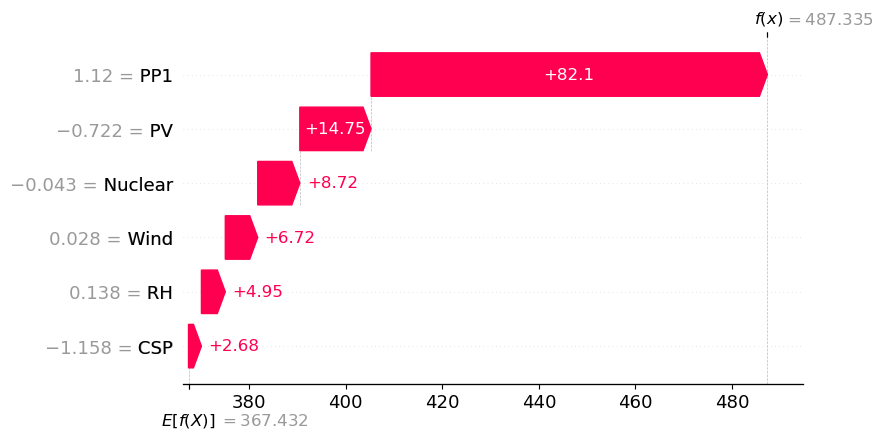

In [ ]:

y_data = y2_data
y_train = y2_train
y_test = y2_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


y2_params = {'C': 35529.565119700674, 'epsilon': 0.01398121990100254, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.00759513082892152}
model_y2 = SVR(**y2_params)
model_y2.fit(X_train, y_train)



# Compute SHAP values
explainer = shap.KernelExplainer(model_y2.predict, X_data)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

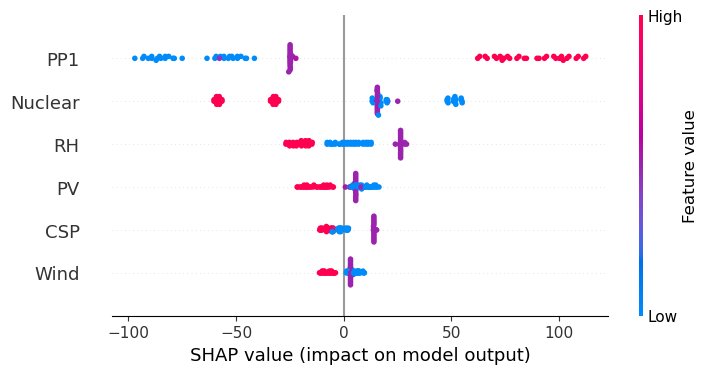

In [ ]:

y_data = y2_data
y_train = y2_train
y_test = y2_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

mod_2 = {'max_depth': 8, 'learning_rate': 0.8058929837921041, 'n_estimators': 707, 'min_child_weight': 6, 'gamma': 0.6203690244688376, 'subsample': 0.8633675242642986, 'colsample_bytree': 0.351803542599373, 'reg_alpha': 0.38202482253134534, 'reg_lambda': 0.19326434501771286, 'random_state': 507}

model_y2 = XGBRegressor(**mod_2)
model_y2.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model_y2, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)

  0%|          | 0/1 [00:00<?, ?it/s]

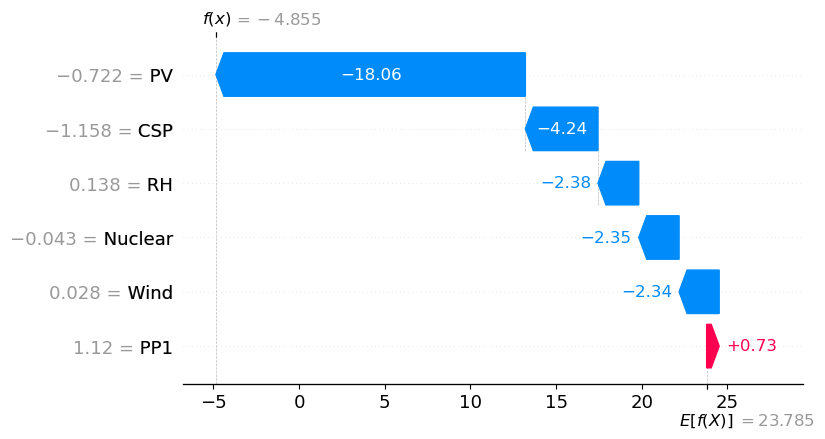

In [ ]:

y_data = y3_data
y_train = y3_train
y_test = y3_test

# Import necessary libraries
import shap
from xgboost import XGBRegressor
import pandas as pd

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

# Define the parameters for the XGBRegressor
y3_params = {'C': 741046.8928371427, 'epsilon': 0.010895466956371502, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.009751068786055191}
model_y3 = SVR(**y3_params)
model_y3.fit(X_data, y_data)


# Compute SHAP values
explainer = shap.KernelExplainer(model_y3.predict, X_data)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)


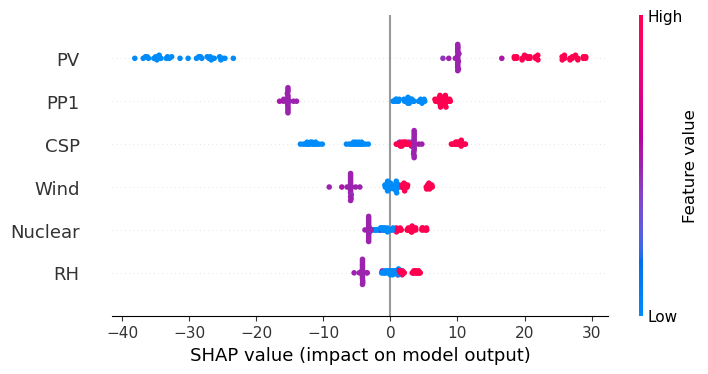

In [ ]:

y_data = y3_data
y_train = y3_train
y_test = y3_test

# Import necessary libraries
import shap
from xgboost import XGBRegressor
import pandas as pd

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

# Define the parameters for the XGBRegressor
y3_params = {'max_depth': 3, 'learning_rate': 0.5560764434875813, 'n_estimators': 581, 'min_child_weight': 1, 'gamma': 0.17663683708839756, 'subsample': 0.22400187438994715, 'colsample_bytree': 0.45123077147598545, 'reg_alpha': 0.8358287950607348, 'reg_lambda': 0.3030245049556971, 'random_state': 475}

# Fit the model
model_y3 = XGBRegressor(**y3_params)
model_y3.fit(X_data, y_data)


# Compute SHAP values
explainer = shap.Explainer(model_y3, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)


  0%|          | 0/1 [00:00<?, ?it/s]

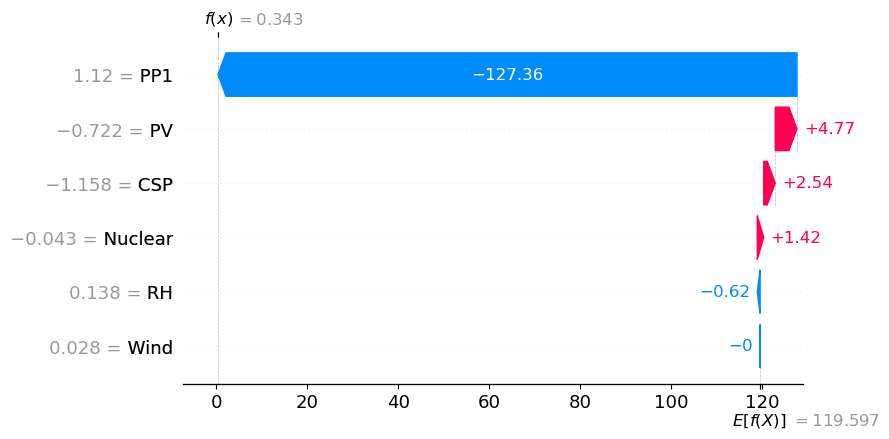

In [ ]:

y_data = y4_data
y_train = y4_train
y_test = y4_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


model_y4 = MLPRegressor(hidden_layer_sizes=(33, 10, 8, 40), activation='relu', alpha=0.20068666427656182, solver='lbfgs', random_state=52)
model_y4.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.KernelExplainer(model_y4.predict, X_train)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

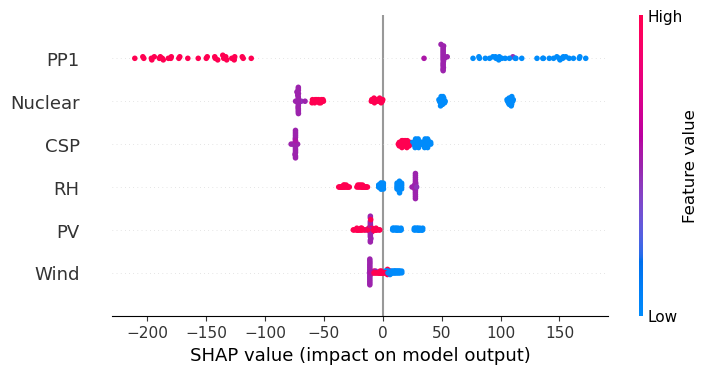

In [ ]:

y_data = y4_data
y_train = y4_train
y_test = y4_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


mod_4 = {'max_depth': 10, 'learning_rate': 0.43666973070690324, 'n_estimators': 828, 'min_child_weight': 8, 'gamma': 0.28078926083310424, 'subsample': 0.6681118230081214, 'colsample_bytree': 0.4876447096098242, 'reg_alpha': 0.29034765465801493, 'reg_lambda': 0.3669174369705459, 'random_state': 949}

model_y4 = XGBRegressor(**mod_4)
model_y4.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.Explainer(model_y4, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)